<a href="https://colab.research.google.com/github/vanessacannizzaropolimi/US_Simulation/blob/main/examples/us_bmode_phased_array/us_bmode_phased_array_from_ct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install k-Wave-python and import libraries

In [10]:
%%capture
!pip install git+https://github.com/waltsims/k-wave-python

In [11]:
from copy import deepcopy

import numpy as np
import nibabel as nib
import scipy.io
from matplotlib import pyplot as plt

from kwave.data import Vector
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2D
from kwave.kspaceFirstOrder3D import kspaceFirstOrder3D
from kwave.ktransducer import NotATransducer, kWaveTransducerSimple
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.options.simulation_options import SimulationOptions
from kwave.reconstruction.beamform import envelope_detection, scan_conversion
from kwave.reconstruction.tools import log_compression
from kwave.utils.conversion import db2neper
from kwave.utils.dotdictionary import dotdict
from kwave.utils.filters import gaussian_filter
# from kwave.utils.mapgen import make_ball
from kwave.utils.signals import get_win, tone_burst
from kwave.utils.conversion import hounsfield2density, hounsfield2soundspeed

Settings

In [12]:
DATA_CAST = 'single'
RUN_SIMULATION = True

# CT file
filename = 'volumeAdjusted.nii'

# Transducer
ELEM_LENGTH = 1

Load CT NIfTI file and extract central slice

In [13]:
ct_img                         = nib.load(filename)
ct_vol                         = ct_img.get_fdata()
dx_mm, dy_mm, dz_mm            = ct_img.header.get_zooms()  # 3d spacing in mm
lateral_spacing, depth_spacing, dz = dx_mm/1000.0, dy_mm/1000.0, dz_mm/1000.0 # 2d spacing in m
# dz = 0.1e-3

Nx, Ny, Nz = ct_vol.shape
slice_idx  = round(Nz // 2)

# extract slice
# slice_idx = ct_vol.shape[2] // 2
# ct_slice  = np.flipud(ct_vol[:, :, slice_idx]) # shape = (Nx, Ny)
# Nx, Ny    = ct_slice.shape                     # Nx = lateral, Ny = spacing
# needed_Nz = ELEM_LENGTH + 1

Conversion HU -> acoustic properties: density [kg/m^3] and sound speed [m/s]

In [14]:
density_map     = hounsfield2density(ct_vol, plot_fitting=False).astype(np.float32) # :contentReference[oaicite:0]{index=0}
sound_speed_map = hounsfield2soundspeed(ct_vol).astype(np.float32)                  # :contentReference[oaicite:1]{index=1}

2D grid and temporal dependencies

In [15]:
# |<- PML ->|<------ computational domain ------>|<- PML ->|
# |pml_size pts   (Nx - 2*pml_size) pts      pml_size pts|
pml_size_points     = Vector([10, 10, 10])                  # [grid points]

grid_size_points    = Vector([Nx, Ny, Nz]) - 2 * pml_size_points
grid_spacing_meters = Vector([lateral_spacing,
                              depth_spacing,
                              dz]) # grid spacing is given by ct resolution

kgrid               = kWaveGrid(grid_size_points, grid_spacing_meters)

c0           = 1540
# c0           = np.max(sound_speed)
domain_depth = grid_size_points.y * grid_spacing_meters.y # depth [m]
t_end        = domain_depth * 2.2 / c0                    # [s], 2.2 is safety factor for overshoot
kgrid.makeTime(c0, t_end = t_end)

(Vector([[0.00000000e+00, 1.36972416e-07, 2.73944831e-07, ...,
          4.93922531e-04, 4.94059503e-04, 4.94196475e-04]]),
 Vector(1.36972416e-07))

Medium

In [16]:
medium = kWaveMedium(
  sound_speed = None,
  density     = None,
  alpha_coeff = 0.75,
  alpha_power = 1.5,
  BonA        = 6
)

Input signal

In [17]:
source_strength   = 1e6  # [Pa] pressure amplitude
tone_burst_freq   = 1e6  # [Hz] burst central frequency
tone_burst_cycles = 4    # burst cycles
rho0              = 1000

input_signal = tone_burst(1 / kgrid.dt, tone_burst_freq, tone_burst_cycles)
input_signal = (source_strength / (c0 * rho0)) * input_signal

Transducer

In [18]:
transducer                 = dotdict()
transducer.number_elements = 64            # total number of transducer elements
transducer.element_width   = 1             # width of each element [grid points]
transducer.element_length  = ELEM_LENGTH   # length of each element [grid points]
transducer.element_spacing = 0             # spacing (kerf  width) between the elements [grid points]
transducer.radius          = float('inf')  # radius of curvature of the transducer [m]

# calculate the width of the transducer in grid points
transducer_width = (
    transducer.number_elements * transducer.element_width
    + (transducer.number_elements - 1) * transducer.element_spacing
)

# use this to position the transducer in the middle of the computational grid
lateral_start_index = int(np.round(grid_size_points.x/2 - transducer_width/2))
depth_start_index   = 1
z_start_index       = slice_idx + 1

transducer.position = [lateral_start_index,
                       depth_start_index,
                       z_start_index]

transducer          = kWaveTransducerSimple(kgrid, **transducer)

“Not-A-Transducer” for source/sensor

In [19]:
not_transducer                      = dotdict()
not_transducer.sound_speed          = c0  # sound speed [m/s]
not_transducer.focus_distance       = 30e-3  # focus distance [m]
not_transducer.elevation_focus_distance = 30e-3  # focus distance in the elevation plane [m]
not_transducer.steering_angle       = 0  # steering angle [degrees]
not_transducer.steering_angle_max   = 32  # steering angle [degrees]
not_transducer.transmit_apodization = 'Hanning'
not_transducer.receive_apodization  = 'Rectangular'
not_transducer.active_elements      = np.ones((transducer.number_elements, 1))
not_transducer.input_signal         = input_signal

not_transducer                      = NotATransducer(transducer, kgrid, **not_transducer)

Random scatters (speckle-like)

In [20]:
# define a random distribution of scatterers
background_map_mean = 1
background_map_std  = 0.008
background_map      = background_map_mean + background_map_std * np.random.randn(kgrid.Nx, kgrid.Ny, kgrid.Nz)

sound_speed_map     = c0 * background_map
density_map         = rho0 * background_map

# add scatters to medium
medium.sound_speed  = sound_speed_map.astype(np.float32)
medium.density      = density_map.astype(np.float32)

In [21]:
'''
# Segment the bone structures on the CT slice and apply enhanced scattering properties to those regions
# 1. Segment the region of interest on the CT slice (e.g., bone) based on Hounsfield Units
hu_threshold = 300                        # HU threshold above which voxels are considered bone
bone_mask    = (ct_slice > hu_threshold) # boolean mask of the high-density region

# 2. Generate scattering parameters for that region (reusing your clipping logic)
scattering_map = np.random.randn(*ct_slice.shape)             # random perturbation map
scattering_c0   = np.clip(                           # clamp sound speed values between 1400 and 1600 m/s
    c0 + 25 + 75 * scattering_map,
    1400,
    1600
)
scattering_rho0 = scattering_c0 / 1.5                    # density values proportional to sound speed

# 3. Overwrite the CT-derived maps only where the mask is True
sound_speed_map[bone_mask] = scattering_c0[bone_mask]    # apply higher scattering speed in bone regions
density_map    [bone_mask] = scattering_rho0[bone_mask]   # apply corresponding density

# 4. Update the medium with the modified maps
medium.sound_speed = sound_speed_map.astype(np.float32)  # ensure correct dtype for simulation
medium.density     = density_map.astype(np.float32)
'''

'\n# Segment the bone structures on the CT slice and apply enhanced scattering properties to those regions\n# 1. Segment the region of interest on the CT slice (e.g., bone) based on Hounsfield Units\nhu_threshold = 300                        # HU threshold above which voxels are considered bone\nbone_mask    = (ct_slice > hu_threshold) # boolean mask of the high-density region\n\n# 2. Generate scattering parameters for that region (reusing your clipping logic)\nscattering_map = np.random.randn(*ct_slice.shape)             # random perturbation map\nscattering_c0   = np.clip(                           # clamp sound speed values between 1400 and 1600 m/s\n    c0 + 25 + 75 * scattering_map,\n    1400,\n    1600\n)\nscattering_rho0 = scattering_c0 / 1.5                    # density values proportional to sound speed\n\n# 3. Overwrite the CT-derived maps only where the mask is True\nsound_speed_map[bone_mask] = scattering_c0[bone_mask]    # apply higher scattering speed in bone regions\nden

# Run simulation

In [22]:
# define range of steering angles to test and preallocate the storage
steering_angles   = np.arange(-32, 33, 2)
number_scan_lines = len(steering_angles)
scan_lines        = np.zeros((number_scan_lines, kgrid.Nt))

if RUN_SIMULATION:
    for angle_index in range(number_scan_lines):
        print(f'Computing scan line {angle_index} of {number_scan_lines}')

        # set the input settings
        input_filename        = f'example_input_{angle_index}.h5'
        # set the input settings
        simulation_options    = SimulationOptions(
            pml_inside        = False,
            pml_size          = pml_size_points,
            data_cast         = DATA_CAST,
            data_recast       = True,
            save_to_disk      = True,
            input_filename    = input_filename,
            save_to_disk_exit = False
        )

        # Update the current steering angle
        not_transducer.steering_angle = steering_angles[angle_index]

        # RUN 2D K-WAVE SIMULATION
        sensor_data            = kspaceFirstOrder3D(
            medium             = deepcopy(medium),  # Medium is altered in-place in this function
            kgrid              = kgrid,
            source             = not_transducer,
            sensor             = not_transducer,
            simulation_options = simulation_options,
            execution_options  = SimulationExecutionOptions(is_gpu_simulation=True)
        )

        # combine sensor outputs and extract scan line
        raw_pressure      = sensor_data['p'].T
        combined_signal   = not_transducer.combine_sensor_data(raw_pressure)
        scan_lines[angle_index, :] = not_transducer.scan_line(combined_signal)

    # save
    scipy.io.savemat('example_us_phased_array_scan_lines.mat', {'scan_lines': scan_lines})
else:
    scan_lines = scipy.io.loadmat('example_us_phased_array_scan_lines')['scan_lines']

Computing scan line 0 of 33
┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.00GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                             512 x 512 x 75 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   3609 │
├───────────────────────────────────────────────

## PROCESS THE RESULTS
### Remove Input Signal

In [23]:
# Trim the delay offset from the scan line data
t0_offset = int(round(len(input_signal.squeeze())/ 2) + (not_transducer.appended_zeros - not_transducer.beamforming_delays_offset))

scan_lines = scan_lines[:, t0_offset:]

Nt = np.shape(scan_lines)[1]


In [24]:

tukey_win, _ = get_win(Nt * 2, 'Tukey', False, 0.05)
scan_line_win = np.concatenate((np.zeros([1, t0_offset * 2]), tukey_win.T[:, :int(len(tukey_win)/2) - t0_offset * 2]), axis=1)

scan_lines = scan_lines * scan_line_win
# store intermediate results

### Time Gain Compensation

In [25]:
# Create radius variable
r = c0 * np.arange(1, Nt + 1) * kgrid.dt / 2

# Define absorption value and convert to correct units
tgc_alpha_db_cm = medium.alpha_coeff * (tone_burst_freq * 1e-6)**medium.alpha_power
tgc_alpha_np_m = db2neper(tgc_alpha_db_cm) * 100

# Create time gain compensation function
tgc = np.exp(tgc_alpha_np_m * 2 * r)

# Apply the time gain compensation to each of the scan lines
scan_lines *= tgc

### Frequency Filtering

In [26]:
scan_lines_fund = gaussian_filter(scan_lines, 1/kgrid.dt, tone_burst_freq, 100)
scan_lines_harm = gaussian_filter(scan_lines, 1/kgrid.dt, 2 * tone_burst_freq, 30)

### Envelope Detection

In [27]:
scan_lines_fund = envelope_detection(scan_lines_fund)
scan_lines_harm = envelope_detection(scan_lines_harm)

### Log Compression

In [28]:
compression_ratio = 3
scan_lines_fund = log_compression(scan_lines_fund, compression_ratio, True)
scan_lines_harm = log_compression(scan_lines_harm, compression_ratio, True)

/usr/local/lib/python3.11/dist-packages/kwave/reconstruction/tools.py:19: RuntimeWarning: invalid value encountered in divide
  signal = ms * (np.log10(1 + cf * signal / ms) / np.log10(1 + cf))


### Visualization

In [29]:
image_size = [kgrid.Nx * kgrid.dx, kgrid.Ny * kgrid.dy]
image_res = [256, 256]

b_mode_fund = scan_conversion(scan_lines_fund, steering_angles, image_size, c0, kgrid.dt, image_res)
b_mode_harm = scan_conversion(scan_lines_harm, steering_angles, image_size, c0, kgrid.dt, image_res)

In [30]:
# Create the axis variables
x_axis = [0, image_size[0] * 1e3] # [mm]
y_axis = [0, image_size[1] * 1e3]  # [mm]

Text(0.5, 1.0, 'B-Mode Image')

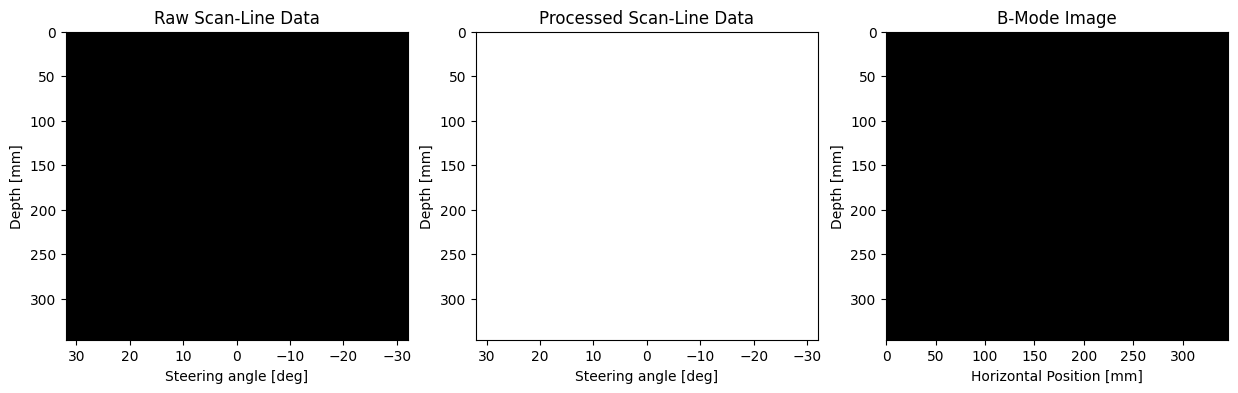

In [31]:
plt.ion()
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(scan_lines.T, aspect='auto',
             extent=[steering_angles[-1], steering_angles[0],y_axis[1], y_axis[0] ], interpolation='none', cmap='gray')
plt.xlabel('Steering angle [deg]')
plt.ylabel('Depth [mm]')
plt.title('Raw Scan-Line Data')


plt.subplot(132)
plt.imshow(scan_lines_fund.T, aspect='auto',
            extent=[steering_angles[-1], steering_angles[0],y_axis[1], y_axis[0] ],  interpolation='none', cmap='bone')
plt.xlabel('Steering angle [deg]')
plt.ylabel('Depth [mm]')
plt.title('Processed Scan-Line Data')

plt.subplot(133)
plt.imshow(b_mode_fund, cmap='bone', aspect='auto',  extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]], interpolation='none')
plt.xlabel('Horizontal Position [mm]')
plt.ylabel('Depth [mm]')
plt.title('B-Mode Image')

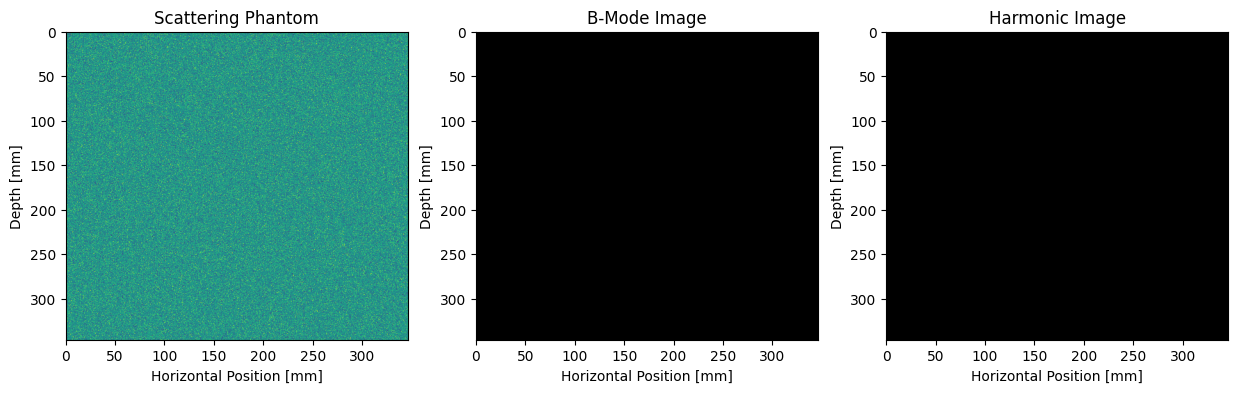

In [32]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(medium.sound_speed[..., kgrid.Nz//2], aspect='auto',
            extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]])
plt.xlabel('Horizontal Position [mm]')
plt.ylabel('Depth [mm]')
plt.title('Scattering Phantom')

plt.subplot(132)
plt.imshow(b_mode_fund, cmap='bone', aspect='auto',  extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]], interpolation='none')
plt.xlabel('Horizontal Position [mm]')
plt.ylabel('Depth [mm]')
plt.title('B-Mode Image')

plt.subplot(133)
plt.imshow(b_mode_harm, cmap='bone', aspect='auto',  extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]], interpolation='none')
plt.xlabel('Horizontal Position [mm]')
plt.ylabel('Depth [mm]')
plt.title('Harmonic Image')

plt.show()
